In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as T

from prior import VQVAEPrior
from experiment import VAEXperiment

from easydict import EasyDict as edict
from analysis.image import show_image
from datamodules import DATAMODULES
from utils import read_config
from tqdm import tqdm

from torchvision.utils import make_grid
from datamodules.datasets import get_datasets

# Loading Model

In [20]:
ckpt_path = "model_logs/dinov2/CIFAR10/codebook_512_64_dinov2_recons_32x32_4reslayers_64resdim/last.ckpt"
ckpt = torch.load(ckpt_path, map_location="cpu")
hparams = edict(ckpt["hyper_parameters"])
model = VAEXperiment(hparams)
model.load_state_dict(ckpt["state_dict"])

_ = model.eval()
_ = model.to("cuda")

num_tokens_h = 8
num_tokens_w = 8


Using cache found in /home/nazir/.cache/torch/hub/facebookresearch_dinov2_main


In [6]:
mlp_hparams = edict(read_config("configs/classifier/mlp_one_hot.yaml"))

codebook_datamodule = DATAMODULES["Codebook"](mlp_hparams)

# Utils

In [7]:
def decode_indices(vq_vae, encoding_indices, device, input_shape):

    encoding_indices = torch.from_numpy(encoding_indices).unsqueeze(1).to(device)

    with torch.no_grad():
    # A one hot representation of indices
        encodings = torch.zeros(
            encoding_indices.shape[0], vq_vae.vq._num_embeddings, device=device)  # [BHW, K]
        encodings.scatter_(1, encoding_indices, 1)
        # print(encodings.shape)

        # Quantize and unflatten
        quantized = torch.matmul(
            encodings, vq_vae.vq._embedding.weight).view(input_shape)  # [BHW, K] x [K, C] -> [BHW, C] -> [B, H, W, C]

        recon = vq_vae.decode(quantized.permute(0, 3, 1, 2).contiguous())
    
    return recon.cpu()

def get_codebook_indices(vq_vae, x, device="cuda"):
    with torch.no_grad():
        codebook_outputs = vq_vae.vq(vq_vae.pre_vq_conv(vq_vae.encoder(x.unsqueeze(0).to(device))))
    encoding_indices = codebook_outputs.encoding_indices.squeeze().cpu().numpy()
    return encoding_indices

def apply_random_shuffle(x, num_tokens, shuffle_len):

    start = np.random.choice(np.arange(num_tokens - shuffle_len))
    end = start + shuffle_len
    np.random.shuffle(x[start:end])

    return x


In [10]:
IMAGENET_MEAN, IMAGENET_STD = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

DATASETS = get_datasets(
    root='/home/nazir/datasets',
    transforms=edict(
        CIFAR10=T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ]),
        CELEBA=T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ]),
        OMNIGLOT=T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x.repeat(3, 1, 1)),
        T.Resize((224, 224)),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ]),
    )
)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /home/nazir/datasets/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


# Random Generation

In [16]:
# generage 8x8 grid of images for random indices decoded, group the images using torchvision make_grid

images = []
for i in range(8 * 8):
    indices = np.random.randint(0, hparams.MODEL.NUM_EMBEDDINGS, size=num_tokens_w*num_tokens_h)
    recon = decode_indices(model.model, indices, "cuda", (1, num_tokens_h, num_tokens_w, hparams.MODEL.EMBEDDING_DIM))
    images.append(recon.squeeze() + 0.5)

grid = make_grid(images, nrow=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


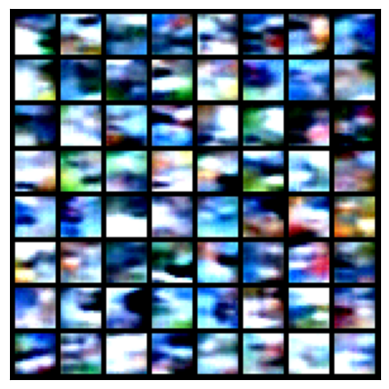

In [17]:
show_image(grid)

# Random Segment Shuffle Corruption

/home/nazir/anaconda3/envs/vae_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


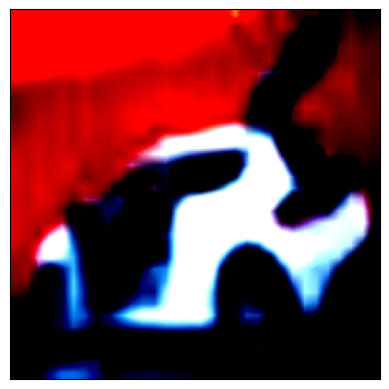

In [18]:
x, y = DATASETS.CIFAR10[6]

show_image(x + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


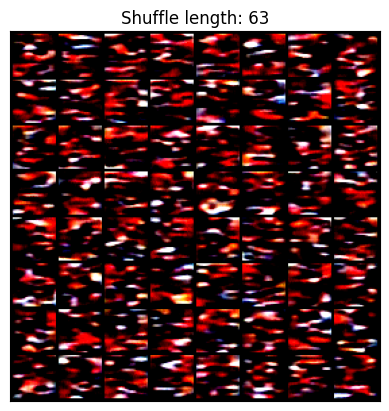

In [28]:
images = []
shuffle_len = 48

for i in range(8 * 8):

    indices = get_codebook_indices(model.model, x)
    indices_shuffled = apply_random_shuffle(indices, num_tokens_h * num_tokens_w, shuffle_len=shuffle_len)
    images.append(decode_indices(model.model, indices_shuffled, "cuda", (1, num_tokens_h, num_tokens_w, hparams.MODEL.EMBEDDING_DIM)).squeeze() + 0.5)

grid = make_grid(images, nrow=8)

show_image(grid, title=f"Shuffle length: {shuffle_len}")

# Random Insertion Corruption

/home/nazir/anaconda3/envs/vae_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


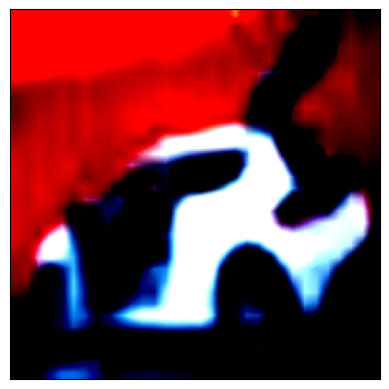

In [29]:
x, y = DATASETS.CIFAR10[6]

show_image(x + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


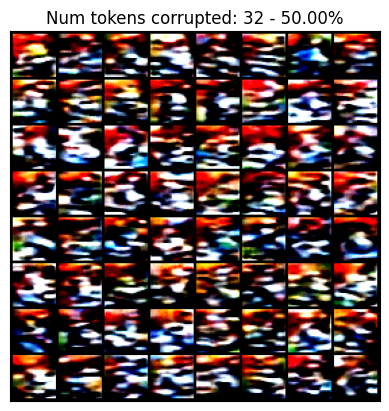

In [34]:
num_tokens_corrupted = 32

images = []

for i in range(8 * 8):

    indices = get_codebook_indices(model.model, x)
    chosen_indices = np.random.choice(np.arange(num_tokens_w * num_tokens_h), size=num_tokens_corrupted, replace=False)
    impure_tokens = np.random.choice(np.arange(hparams.MODEL.NUM_EMBEDDINGS), size=num_tokens_corrupted, replace=True)

    indices[chosen_indices] = impure_tokens

    images.append(decode_indices(model.model, indices, "cuda", (1, num_tokens_h, num_tokens_w, hparams.MODEL.EMBEDDING_DIM)).squeeze() + 0.5)

grid = make_grid(images, nrow=8)

show_image(grid, title=f"Num tokens corrupted: {num_tokens_corrupted} - {num_tokens_corrupted / (num_tokens_h * num_tokens_w) * 100:.2f}%")

# Relationships of Codebook Vectors

In [360]:
vq_vae = model.model

In [ ]:
# what is the best way to plot the pairwise distances between a set of vecotrs ?    

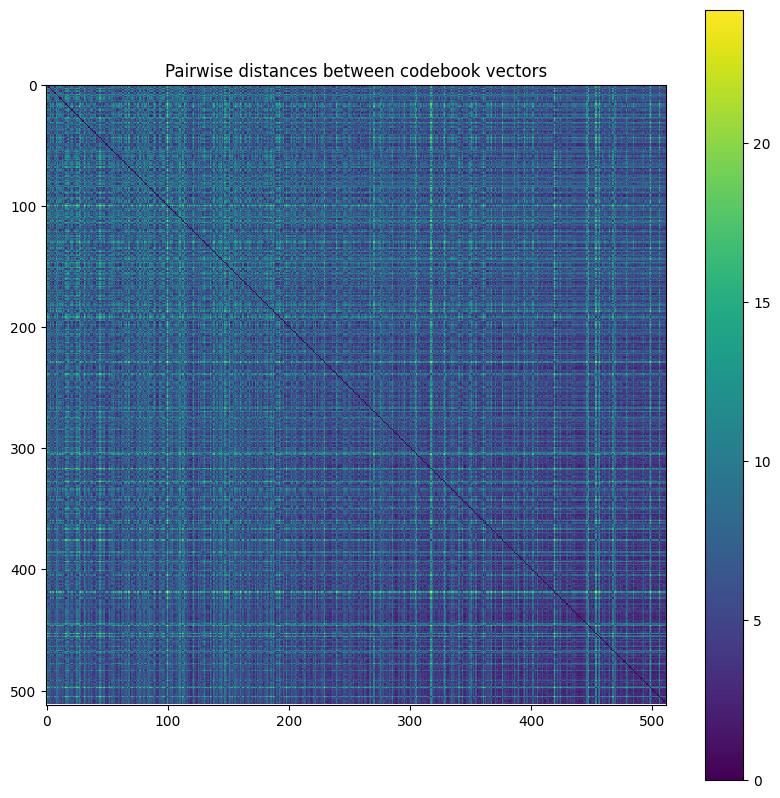

In [263]:
# turn codebook Parameters object to pytorch tensor
codebook = vq_vae.vq._embedding.weight

# compute pairwise distances between all codebook vectors
distances = torch.cdist(codebook, codebook)

# visualize heatmap of pairwise distances
plt.figure(figsize=(10, 10))
plt.imshow(distances.detach().cpu().numpy(), cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Pairwise distances between codebook vectors")
plt.show()


/home/nazir/anaconda3/envs/vae_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


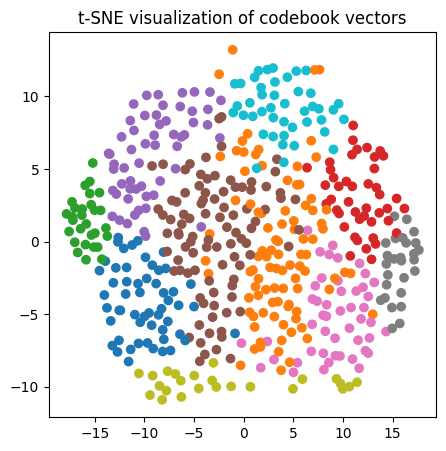

In [259]:
# apply k-means clustering on codebook vectors

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(codebook.detach().cpu().numpy())

# visualize cluster assignments of codebook vectors using t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
codebook_tsne = tsne.fit_transform(codebook.detach().cpu().numpy())

plt.figure(figsize=(5, 5))
plt.scatter(codebook_tsne[:, 0], codebook_tsne[:, 1], c=kmeans.labels_, cmap="tab10")
plt.title("t-SNE visualization of codebook vectors")
plt.show()


In [276]:
# get the top 5 numbers in distances tensor and their indices

top_k = 5

top_k_distances, top_k_indices = torch.topk(distances.view(-1), k=top_k)

top_k_distances, top_k_indices

(tensor([24.1778, 24.1778, 22.8390, 22.8390, 22.8004], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([214628,  51619,  51647, 228964, 162723], device='cuda:0'))

# Meaning of Individual Codebook Vectors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


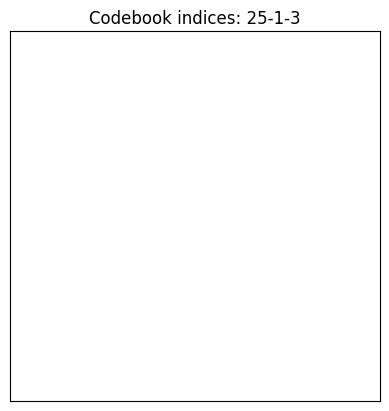

In [39]:
codebook_index = 3

indices = (np.ones(64) * codebook_index).astype(np.int64)
indices = np.concatenate([np.ones(20, dtype=np.int64)*0 , np.ones(20, dtype=np.int64) * 1, np.ones(24, dtype=np.int64) * 2])

# create indices variable of size 64 with alternating tiled 0 and 2

indices = np.tile(np.array([0, 11]), 32)


recon = decode_indices(model.model, indices, "cuda", (1, 8, 8, hparams.MODEL.EMBEDDING_DIM)).squeeze() + 0.5
show_image(recon, title=f"Codebook indices: 25-1-3")

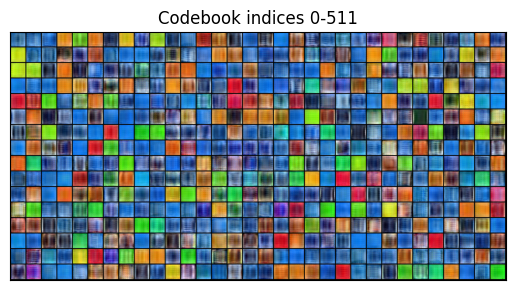

In [44]:
images = []
for i in range(hparams.MODEL.NUM_EMBEDDINGS):

    indices = (np.ones(64) * i).astype(np.int64)
    recon = decode_indices(model.model, indices, "cuda", (1, 8, 8, hparams.MODEL.EMBEDDING_DIM)).squeeze()
    images.append(recon)

grid = make_grid(images, nrow=32, normalize=True, scale_each=True)

show_image(grid, title=f"Codebook indices 0-511")

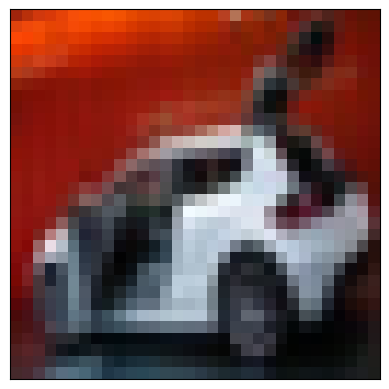

In [26]:
# 7 - 13 -> 2

x, y = DATASETS.CIFAR10[6]

show_image(x + 0.5)

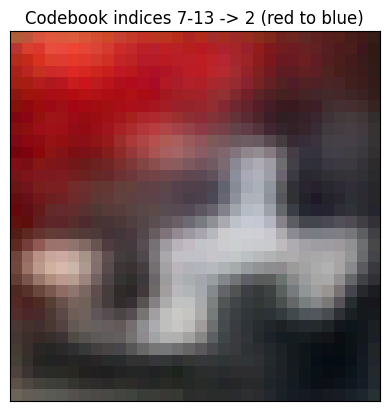

In [27]:
indices = get_codebook_indices(model.model, x)

indices[indices == 7] = 2
indices[indices == 13] = 2

recon = decode_indices(model.model, indices, "cuda", (1, num_tokens_h, num_tokens_w, hparams.MODEL.EMBEDDING_DIM)).squeeze() + 0.5

show_image(recon, title=f"Codebook indices 7-13 -> 2 (red to blue)")

In [28]:
hparams

{'MODEL': {'NAME': 'VQVAE_V2',
  'IN_CHANNELS': 3,
  'EMBEDDING_DIM': 64,
  'NUM_EMBEDDINGS': 512,
  'IMG_SIZE': 64,
  'BETA': 0.25,
  'USE_EMA': True,
  'DECAY': 0.99,
  'HIDDEN_DIM': [128, 64, 32],
  'NUM_RESIDUAL_LAYERS': 2,
  'RESIDUAL_HIDDEN_DIM': 32,
  'DATA_VARIANCE': 0.06328},
 'DATA': {'ROOT': '/home/nazir/datasets',
  'NAME': 'CIFAR10',
  'NORMALIZATION': 'custom',
  'MEAN': [0.5, 0.5, 0.5],
  'STD': [1.0, 1.0, 1.0],
  'NUM_CLASSES': 10,
  'CLS_SUBSET': None},
 'SOLVER': {'BATCH_SIZE': 256,
  'PATCH_SIZE': 256,
  'NUM_WORKERS': 20,
  'LR': 0.001,
  'WEIGHT_DECAY': 0.0,
  'SCHEDULER_GAMMA': 0.0,
  'KLD_WEIGHT': 0.00025,
  'MAX_EPOCHS': 40,
  'MAX_STEPS': 15000,
  'PRECISION': 32},
 'WANDB': {'ACTIVATE': True,
  'RUN_NAME': 'flex_4x4_features_512_64_conv_t_after_res',
  'PROJECT': 'vq_vae',
  'NUM_LOG_IMGS': 36,
  'LOG_DIR': 'logs/codebook/'},
 'CKPT': {'DIR_PATH': 'model_logs/bottleneck/', 'EVERY_N_EPOCHS': 1},
 'RANDOM_SEED': 2000}